## cfos_batch_combination_20201125_any_division
The purpose of this notebook is to do some exploratory data analysis to try to visualize and ultimately understand what is causing the differences in fractional counts between c-Fos brains from different batches.

One of the questions we want to answer is: are the differences between brains from different batches larger than the differences between brains subject to different experimental conditions?

One way to try to answer this is to compare the total and fractional counts coming from large brain divisions between brains in these groups. 

In this notebook I modify the plotting scripts in previous notebooks to allow for any branch or branches and their levels of the ontology. The idea is to be ready to plot any batch/condition comparison plot for any set of brain regions regardless on the fly, rather than going back and modifying a few lines of code each time.

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import edt
import seaborn as sns
import graphviz

%matplotlib inline

## Data loading and validation

In [2]:
main_file = '../data/animals_eroded_counts_20201125.csv'
old_main_file = '../data/animals_counts.csv'
pma_segment_props_file = '../data/pma_segment_properties_info'
pma_ontology_json_file = '../data/PMA_ontology.json'
brain_divisions_file = '../data/developmentalregions.xlsx' # contains the telencephalon, mesencephalon, etc regions

In [3]:
with open(pma_ontology_json_file,'r') as infile:
    pma_ontology_dict = json.load(infile)

In [4]:
class Node():
    """ For making the ontology graph"""
    def __init__(self,name):
        self.name = name
        self.parent = None
        self.children = [] # list of Node objects
    def __repr__(self):
        return str(self.name)

In [69]:
class Graph():
    """ The ontology graph """
    def __init__(self):
        self.nodes = {} # map name to Node object
    def make_graph(self,dic):
        name = dic.get('name')
        if name not in self.nodes:
            node = Node(name)
            self.nodes[name] = node
        else:
            node = self.nodes[name]
        
        children = dic.get('children')
        for child in children: # child is a dict
            child_name = child.get('name')
            child_node = Node(child_name)
            child_node.parent = node
            self.nodes[child_name] = child_node
            node.children.append(child_node)
            self.make_graph(child)
    def print_branch(self,nodename,level=0,stoplevel=2):
        """ 
        ---PURPOSE---
        Print out the branch of this ontology, 
        starting with a parent node name
        ---INPUT---
        nodename     The parent node you want to start at
        level        An internal variable. Do not modify.
        stoplevel    The number of levels down from the parent 
                     node that you want to print. 
                     Use -1 to print the entire branch out
        """
        if stoplevel == -1:
            pass
        elif level > stoplevel:
            return
        print(level,nodename)
        for child in self.nodes[nodename].children:
            self.print_branch(child.name,level+1,stoplevel=stoplevel)
        level-=1
        print()
    def visualize_graph(self,nodename,stoplevel):
        """ 
        ---PURPOSE---
        Visualize a graph starting at a given node
        and stopping at a certain number of levels down 
        the ontology.
        ---INPUT---
        nodename     The parent node you want to start at
        stoplevel    The number of levels down from the parent 
                     node that you want to print
        """
        graph = graphviz.Digraph()
        self.fill_viz_graph(nodename=nodename,graph=graph,level=0,stoplevel=stoplevel)
        return graph
    def fill_viz_graph(self,nodename,graph,level,stoplevel):
        if stoplevel == -1:
            pass
        elif level >= stoplevel:
            return
        graph.node(nodename)
        for child in self.nodes[nodename].children:
            graph.edge(nodename,child.name)
            self.fill_viz_graph(child.name,graph=graph,level=level+1,stoplevel=stoplevel)
        level-=1
        return

In [70]:
# Make a graph containing all brain regions as nodes and parent-child relationships as edges
graph = Graph()
graph.make_graph(pma_ontology_dict)

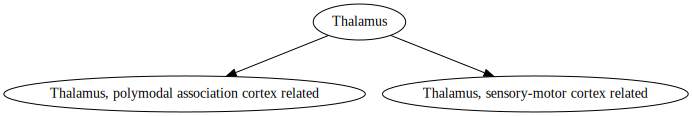

In [71]:
graph.visualize_graph("Thalamus",stoplevel=1) # show only 1 level down

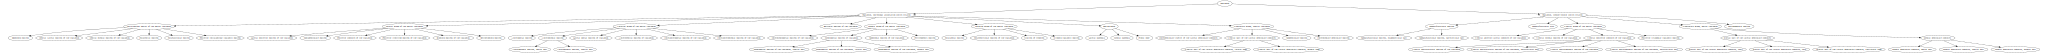

In [72]:
graph.visualize_graph("Thalamus",stoplevel=-1) # show all levels down

In [112]:
graph.print_branch("Thalamus",stoplevel=2)

0 Thalamus
1 Thalamus, polymodal association cortex related
2 Intralaminar nuclei of the dorsal thalamus

2 Lateral group of the dorsal thalamus

2 Anterior group of the dorsal thalamus

2 Reticular nucleus of the thalamus

2 Medial group of the dorsal thalamus

2 Midline group of the dorsal thalamus

2 Epithalamus

2 Geniculate group, ventral thalamus


1 Thalamus, sensory-motor cortex related
2 Subparafascicular nucleus

2 Subparafascicular area

2 Ventral group of the dorsal thalamus

2 Geniculate group, dorsal thalamus

2 Peripeduncular nucleus





In [113]:
graph.print_branch("Thalamus",stoplevel=-1)

0 Thalamus
1 Thalamus, polymodal association cortex related
2 Intralaminar nuclei of the dorsal thalamus
3 Rhomboid nucleus

3 Central lateral nucleus of the thalamus

3 Central medial nucleus of the thalamus

3 Paracentral nucleus

3 Parafascicular nucleus

3 Posterior intralaminar thalamic nucleus


2 Lateral group of the dorsal thalamus
3 Lateral posterior nucleus of the thalamus

3 Suprageniculate nucleus

3 Posterior complex of the thalamus

3 Posterior limiting nucleus of the thalamus

3 Ethmoid nucleus of the thalamus

3 Retroethmoid nucleus


2 Anterior group of the dorsal thalamus
3 Anterodorsal nucleus

3 Anteromedial nucleus
4 Anteromedial nucleus, dorsal part

4 Anteromedial nucleus, ventral part


3 Lateral dorsal nucleus of thalamus

3 Anteroventral nucleus of thalamus

3 Interanterodorsal nucleus of the thalamus

3 Interanteromedial nucleus of the thalamus


2 Reticular nucleus of the thalamus

2 Medial group of the dorsal thalamus
3 Intermediodorsal nucleus of the thala

In [85]:
graph.print_branch("Brain stem",stoplevel=2)

0 Brain stem
1 Midbrain
2 Midbrain, motor related

2 Midbrain, sensory related

2 Midbrain, behavioral state related


1 Hindbrain
2 Medulla

2 Pons


1 Interbrain
2 Thalamus

2 Hypothalamus





In [9]:
# Read in the new dataframe containing cell counts in each PMA brain region
main_df = pd.read_csv(main_file)
main_df

,brain,brain_longname,condition,batch,root,Midbrain,Oculomotor nucleus,Medial terminal nucleus of the accessory optic tract,Lateral terminal nucleus of the accessory optic tract,Dorsal terminal nucleus of the accessory optic tract,...,supraoptic commissures,fasciculus retroflexus,habenular commissure,stria medullaris,nigrostriatal tract,rubrospinal tract,ventral tegmental decussation,crossed tectospinal pathway,direct tectospinal pathway,doral tegmental decussation
0,dadult_pc_crus1_1,dadult_pc_crus1_1,vector_control_reversal,201810_adultacutePC_ymaze_cfos,1,3287,1,20,2,24,...,12,19,1,24,45,36,2,27,0,0
1,dadult_pc_crus1_10,dadult_pc_crus1_10,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,dadult_pc_crus1_2,dadult_pc_crus1_2,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0,1155,1,3,7,16,...,5,5,0,30,13,7,0,11,0,0
3,dadult_pc_crus1_3,dadult_pc_crus1_3,vector_control_reversal,201810_adultacutePC_ymaze_cfos,1,3182,0,8,5,1,...,13,17,3,24,21,33,2,24,0,0
4,dadult_pc_crus1_4,dadult_pc_crus1_4,vector_control_reversal,201810_adultacutePC_ymaze_cfos,0,2343,0,2,18,10,...,10,6,0,10,19,30,2,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,an026,an026,acquisition_day2,202010_cfos,0,5989,3,48,20,0,...,29,9,0,3,2,94,0,15,0,0
167,an027,an027,acquisition_day2,202010_cfos,0,9258,5,45,22,8,...,56,26,0,42,64,137,10,15,0,0
168,an028,an028,acquisition_day2,202010_cfos,9,9192,0,16,4,11,...,71,8,0,5,39,233,20,14,0,0
169,an029,an029,acquisition_day2,202010_cfos,2,2282,0,14,6,0,...,12,5,0,16,33,152,0,6,0,1


As always we need our get_progeny() function to get the list of progeny given a region

In [10]:
def get_progeny(dic,parent_structure,progeny_list):
    """ 
    ---PURPOSE---
    Get a list of all progeny of a structure name.
    This is a recursive function which is why progeny_list is an
    argument and is not returned.
    ---INPUT---
    dic                  A dictionary representing the JSON file 
                         which contains the ontology of interest
    parent_structure     The structure
    progeny_list         The list to which this function will 
                         append the progeny structures. 
    """
    name = dic.get('name')
    children = dic.get('children')
    if name == parent_structure:
        for child in children: # child is a dict
            child_name = child.get('name')
            progeny_list.append(child_name)
            get_progeny(child,parent_structure=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get('name')
        get_progeny(child,parent_structure=parent_structure,progeny_list=progeny_list)
    return

We also need a function to get total counts from a given region for a given brain. 

In [11]:
def get_total_counts(soi,series,debug=False):
    """ Get the total counts in a region
    and all of its descendent regions 
    from a single dataframe series (single brain)
    
    ---INPUT---
    soi    region name of interest
    seires pandas series representing a row (single brain) from the main dataframe
    ---OUTPUT---
    total  the total number of summed
    """
    
    progeny_list=[]
    get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
    total=0 #store counts in this list
    # Add the counts for the region itself, if that region is in the dataframe
    try:
        total+=series[soi]
        if debug:
            print(f"{soi} is in dataframe!")
    except:
        if debug:
            print(f"{soi} not in dataframe")
        pass
    for progen in progeny_list:
        try:
            
            count = int(series[progen])
            if debug:
                print(f"{progen} is in dataframe!")
            total+=count    
        except:
            if debug:
                print(f"{progen} not in dataframe")
            pass
    return total

Here is where things diverge from previous notebooks. In the past, we have made a custom dictionary up here and then used this in all of the scripts below. Instead, we want to be able to feed a list of brain regions into the scripts below.

In [13]:
# Provided by Sam
brain_division_dict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain','Hindbrain'],
#     'Metencephalon':['Cerebellum']
                      }

In [15]:
def get_fractional_counts(soi,series,normalizing_counts,debug=False):
    """ Get the fractional counts in a region
    and all of its descendent regions.
    
    ---INPUT---
    soi                 region name of interest
    seires              pandas series representing a row (single brain) from the main dataframe
    normalizing_counts  The total counts to use as the denominator for calculating the fraction 
    ---OUTPUT---
    The fractional count of the single soi out of the entire Telencephalon, Diencephalon, Mesencephalon
    """
    
    progeny_list=[]
    get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
    total=0 #store counts in this list
    # Add the counts for the region itself, if that region is in the dataframe
    try:
        total+=series[soi]
        if debug:
            print(f"{soi} is in dataframe!")
    except:
        if debug:
            print(f"{soi} not in dataframe")
        pass
    for progen in progeny_list:
        try:
            count = int(series[progen])
            if debug:
                print(f"{progen} is in dataframe!")
            total+=count    
        except:
            if debug:
                print(f"{progen} not in dataframe")
            pass
    return total/normalizing_counts

OK so now we have a way to get the fractional counts from any region, regardless of whether it is in the dataframe

Now what we want to do is figure out the fractional counts coming from several main brain areas for each brain in a batch and make a boxplot

In [28]:
%%time
# Let's calculate the fractional counts from each of these large brain divisions for the single test brain
total_frac = 0
for division in brain_division_dict:
    subregions = brain_division_dict[division]
    frac_counts = [get_fractional_counts(soi,test_brain_series) for soi in subregions]
    total_frac += sum(frac_counts)
    print(division,sum(frac_counts))
print(total_frac)

Telencephalon 0.5902251537809555
Diencephalon 0.1254500138465799
Mesencephalon 0.28432483237246464
1.0
CPU times: user 17.5 ms, sys: 1.64 ms, total: 19.2 ms
Wall time: 24.9 ms


In [30]:
%%time
# Let's calculate the total counts from each of these large brain divisions for the single test brain
total_counts = 0
for division in brain_division_dict:
    subregions = brain_division_dict[division]
    counts = [get_total_counts(soi,test_brain_series) for soi in subregions]
    total_counts += sum(counts)
    print(division,sum(counts))
sum_df = test_brain_series['sumcounts_tdm']
print(f"Sum of all counts is {total_counts} -- should sum up to {sum_df}")

Telencephalon 70333
Diencephalon 14949
Mesencephalon 33881
Sum of all counts is 119163 -- should sum up to 119163
CPU times: user 16.2 ms, sys: 2.23 ms, total: 18.5 ms
Wall time: 20 ms


# Helper scripts for plots

In [16]:
# helper functions for plots below
def get_counts_dict(brain_division_dict,batch,condition,count_type):
    """ 
    ---PURPOSE---
    Given a batch and condition, calculate either the total or fractional
    counts in each region for each animal in this batch/condition combo
    in the main dataframe  
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    ---OUTPUT---
    counts_dict    dictionary[brain][division] = count
    """
    assert count_type in ['frac','total']
    assert batch in main_df['batch'].unique()
    assert condition in main_df['condition'].unique()
    batch_mask = main_df['batch'] == batch
    condition_mask = main_df['condition'] == condition
    comb_mask = np.logical_and(batch_mask,condition_mask)
    batch_condition_df = main_df[comb_mask]
    n_animals = len(batch_condition_df)
    # make a dictionary where keys are Brain names and values are dictionaries mapping brain division
    # to either fractional or total counts
    counts_dict = {}
    for index,brain_series in batch_condition_df.iterrows():
        brain = brain_series['brain']
        # Figure out sum of all regions in the brain division dict to provide normalization
        normalizing_counts = 0
        for division in brain_division_dict:
            brain_regions = brain_division_dict[division]
            total_counts = sum([get_total_counts(region,brain_series) for region in brain_regions])
            normalizing_counts += total_counts

        counts_dict[brain] = {}
        for division in brain_division_dict:
            subregions = brain_division_dict[division]
            if count_type == 'frac':
                counts = [get_fractional_counts(soi,brain_series,normalizing_counts) for soi in subregions]
            elif count_type == 'total':
                counts = [get_total_counts(soi,brain_series) for soi in subregions]
            counts_dict[brain][division] = sum(counts)
    return counts_dict


def create_division_df(brain_division_dict,batch,condition,count_type='frac'):
    """ 
    ---PURPOSE---
    Given a batch and condition create a pandas DataFrame
    containing columns: Brain, Batch, Condition and The major divisions.
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    """
    counts_dict = get_counts_dict(brain_division_dict,batch,condition,count_type)

    counts_by_division = []
    for brain in counts_dict:
        division_dict = {'brain':brain}
        for division in counts_dict[brain]:
            division_dict[division] = counts_dict[brain][division]
        counts_by_division.append(division_dict)
    df = pd.DataFrame(counts_by_division)
    df = df.assign(batch=batch,condition=condition)
    return df

# Plotting functions

In [17]:
def make_seaborn_heatmap_batch_condition(brain_division_dict,batch,condition,count_type='frac',savename=None):
    """ 
    ---PURPOSE---
    Make the cell count or fractional cell count heatmap
    for all animals in a single batch and single condition 
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    savename       if provided, will save the figure using this filename
    ---OUTPUT---
    ax             returns a matplotlib axis object
    """
    counts_dict = get_counts_dict(brain_division_dict,
                                  batch=batch,
                                 condition=condition,
                                 count_type=count_type)
    # now make a heatmap of counts or fractional counts for each animal in the dataframe. 
    frac_counts_ravelled = []

    for brain in counts_dict:
        for division in counts_dict[brain]:
            entry_dict = {'Brain':brain,'Division':division,'Count':counts_dict[brain][division]}
            frac_counts_ravelled.append(entry_dict)
    df_ravelled = pd.DataFrame(frac_counts_ravelled)
    df_pivot = df_ravelled.pivot("Brain", "Division", "Count")
    df_pivot = df_pivot[list(brain_division_dict.keys())]
    f, ax = plt.subplots(figsize=(9, 6))
    if count_type == 'frac':
        title = f"Fractional counts by brain division in \nbatch={batch}\ncondition={condition}"
        fmt = '.2f'
    elif count_type == 'total':
        title = f"Total counts by brain division in \nbatch={batch}\ncondition={condition}"
        fmt = 'd'
    sns.set(font_scale=1.0)
    sns.heatmap(df_pivot, annot=True, fmt=fmt, linewidths=.5, ax=ax)
    ax.set_title(title,fontsize=14)
    ax.set_ylim(0, len(counts_dict))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Division', fontsize = 20) # X label
    ax.set_ylabel('Brain', fontsize = 20) # Y label

    if savename:
        plt.savefig(savename)


In [86]:
legend_fontsize=12

def make_stripplot_fixed_batch(brain_division_dict,batch,condition_list,count_type='frac',savename=None):
    """ 
    ---PURPOSE---
    Given a batch and list of conditions make a stripplot
    comparing either fractional or total counts in different conditions
    at fixed batch 
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    savename       if provided, will save the figure using this filename
    ---OUTPUT---
    ax             returns a matplotlib axis object
    """
    
    df_list = []
    for condition in condition_list:
        df_by_division = create_division_df(brain_division_dict=brain_division_dict,
                                            batch=batch,
                                            condition=condition,
                                            count_type=count_type)
        df_list.append(df_by_division)
    cdf = pd.concat(df_list)   

    cdf.drop(['brain','batch'],axis=1,inplace=True)
    mdf = pd.melt(cdf, id_vars=['condition'], var_name=['Brain division'])
    if count_type == 'frac':
        value_label = 'fraction of counts'
        title = f"Fraction of counts by brain division at fixed batch={batch}"
    elif count_type == 'total':
        value_label = 'total counts'
        title = f"Total counts by brain division at fixed batch={batch}"
    mdf.rename(columns={'value':value_label},inplace=True)
    
    sns.set_theme(style="whitegrid",context="notebook")
    sns.despine(bottom=True, left=True)
    ax=sns.stripplot(y=value_label, x='Brain division', 
                       data=mdf, 
                       jitter=True,
                       dodge=True,
                       marker='o', 
                       alpha=0.4,
                       s=8,
                       hue='condition')

    ax.set_title(title,fontsize=14)
    _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
             rotation_mode="anchor",fontsize=14)
    _=plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_ylabel(value_label, fontsize = 20) # X label
    ax.set_xlabel('Brain Division', fontsize = 20) # Y label
    
    # Improve the legend 
    handles, labels = ax.get_legend_handles_labels()
    counts_df = cdf.groupby('condition')['condition'].count()
    numbers_in_samp_dict = {condition:counts_df[condition] for condition in condition_list}
    ax.legend(handles[0:len(condition_list)], 
              [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(condition_list)]],
              title="Condition",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True,fontsize=legend_fontsize,
             bbox_to_anchor=(1.75, 1))
    if savename:
        plt.savefig(savename)

def make_stripplot_fixed_condition(brain_division_dict,batch_list,condition,count_type='frac'):
    """ Given a list of batches and a condition make a stripplot
    comparing either fractional or total counts in different batches
    at fixed condition """
    
    df_list = []
    for batch in batch_list:
        df_by_division = create_division_df(brain_division_dict=brain_division_dict,
                                            batch=batch,
                                            condition=condition,
                                            count_type=count_type)
        df_list.append(df_by_division)
    cdf = pd.concat(df_list)   

    cdf.drop(['brain','condition'],axis=1,inplace=True)
    mdf = pd.melt(cdf, id_vars=['batch'], var_name=['Brain division'])
    if count_type == 'frac':
        value_label = 'fraction of counts'
        title = f"Fraction of counts by brain division at fixed condition={condition}"
    elif count_type == 'total':
        value_label = 'total counts'
        title = f"Total counts by brain division at fixed condition={condition}"
    mdf.rename(columns={'value':value_label},inplace=True)
    
    # Show the observations as scatter plots
    sns.set_theme(style="whitegrid",context="notebook")
    sns.despine(bottom=True, left=True)
    ax=sns.stripplot(y=value_label, x='Brain division', 
                       data=mdf, 
                       jitter=True,
                       dodge=True,
                       marker='o', 
                       alpha=0.4,
                       s=8,
                       hue='batch')

    ax.set_title(title,fontsize=14)
    _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
             rotation_mode="anchor",fontsize=14)
    _=plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_ylabel(value_label, fontsize = 20) # X label
    ax.set_xlabel('Brain Division', fontsize = 20) # Y label
    
    
    # Improve the legend 
    counts_df = cdf.groupby('batch')['batch'].count()
    numbers_in_samp_dict = {batch:counts_df[batch] for batch in batch_list}
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:len(batch_list)], 
              [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(batch_list)]],
              title="Batch",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True,
             fontsize=legend_fontsize,
             bbox_to_anchor=(1.75, 1))
    # plt.savefig('../cfos_fraccount_fixed_condition_prelim.png')


# Plots

# Heatmaps

## Batch = 201810_adultacutePC_ymaze_cfos

### total counts

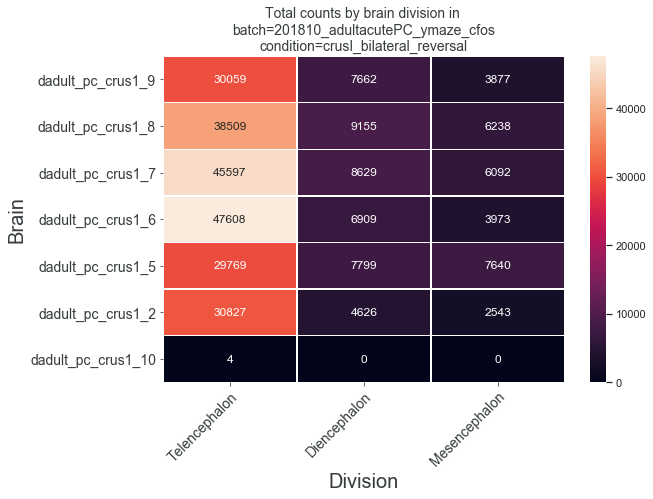

In [18]:
# Provided by Sam
bdict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain','Hindbrain'],
#     'Metencephalon':['Cerebellum']
                      }
make_seaborn_heatmap_batch_condition(brain_division_dict=bdict,
                                     batch='201810_adultacutePC_ymaze_cfos',
                                     condition='crusI_bilateral_reversal',
                                     count_type='total',
                                     savename=None)

## fractional counts

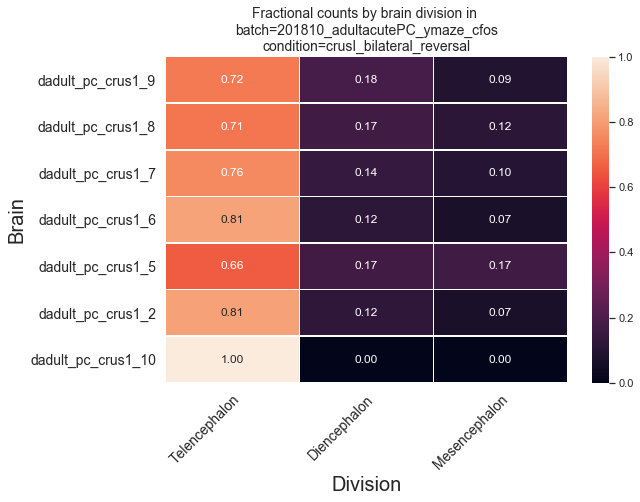

In [21]:
make_seaborn_heatmap_batch_condition(brain_division_dict=bdict,
                                     batch='201810_adultacutePC_ymaze_cfos',
                                     condition='crusI_bilateral_reversal',
                                     count_type='frac',
                                     savename=None)

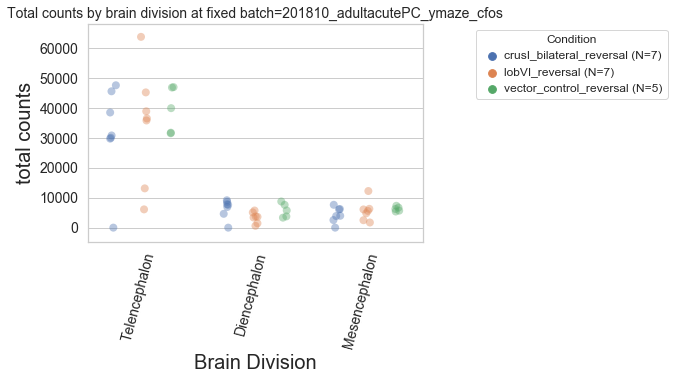

In [24]:
make_stripplot_fixed_batch(brain_division_dict=bdict,
                           batch="201810_adultacutePC_ymaze_cfos",
                           condition_list=["crusI_bilateral_reversal",
                                           "lobVI_reversal",
                                           "vector_control_reversal"],
                           count_type='total')

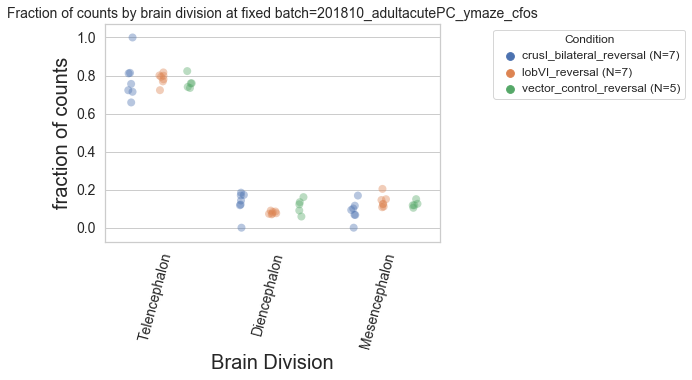

In [25]:
make_stripplot_fixed_batch(brain_division_dict=bdict,
                           batch="201810_adultacutePC_ymaze_cfos",
                           condition_list=["crusI_bilateral_reversal",
                                           "lobVI_reversal",
                                           "vector_control_reversal"],
                           count_type='frac')

# Comparison plots between different batches at fixed condition

# Condition = CNO_control_reversal

### total counts

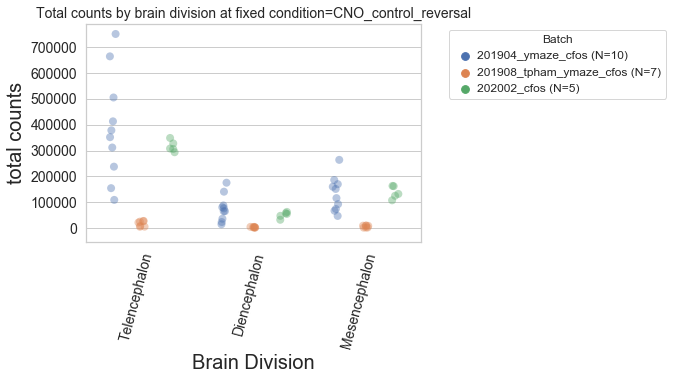

In [28]:
make_stripplot_fixed_condition(brain_division_dict=bdict,
                               batch_list=["201904_ymaze_cfos","201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNO_control_reversal",
                               count_type='total')

### fractional counts

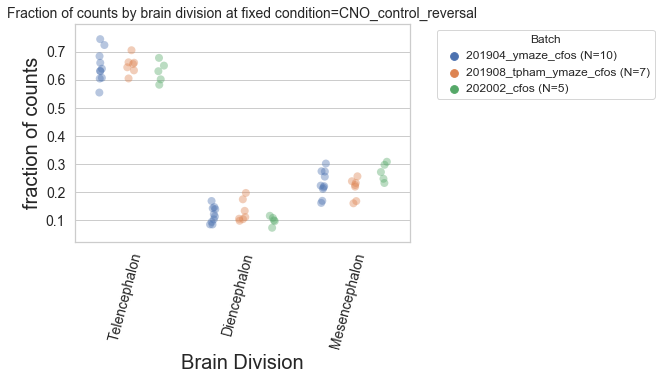

In [29]:
make_stripplot_fixed_condition(brain_division_dict=bdict,
                               batch_list=["201904_ymaze_cfos","201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNO_control_reversal",
                               count_type='frac')

In [87]:
# What if I choose a new brain division dict?
# Provided by Sam
cdict = {
    'Thalamus':["Thalamus",],
    'Hypothalamus':['Hypothalamus'],
#     'Metencephalon':['Cerebellum']
                      }

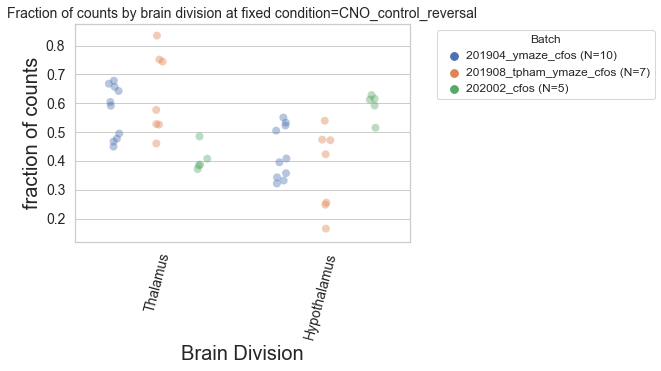

In [88]:
make_stripplot_fixed_condition(brain_division_dict=cdict,
                               batch_list=["201904_ymaze_cfos","201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNO_control_reversal",
                               count_type='frac')